# Data Context

To compare the effect of integrating argument mining in fake news detection we will compare results to the study by Khan et al. (2021): "A Benchmark Study of Machine Learning Models for Online Fake News Detection". 

To replicate this we use the following same 2 datasets:

- *Fake and Real News* dataset from George McIntire (2017) comprising news from the 2016 US election cycle. Not open-source, received via e-mail.

- *Liar* by Wang in "Liar, Liar Pants on Fire" (2017) consists of human-labeled short statements from [Politifact](www.politifact.com).

We also introduce another dataset:

- *Fake or Real News* from Bisaillon from [Kaggle] comprising fake news and real news articles in political context from 2015 to 2018.

My [GitHub repository](https://github.com/himayla/fallacy_fake_news)

# Data Description


In [1]:
# Imports
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download("punkt")
# from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mkersten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mkersten/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Loading

In [2]:
# Load Fake and Real News dataset
fake_real = pd.read_csv("pipeline/text-based/data/fake_real.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'pipeline/text-based/data/fake_real.csv'

In [ ]:
# Load Liar dataset by Wang
labels = ["id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]

liar_train = pd.read_csv("data/liar/train.tsv", sep="\t", names=labels)
liar_valid = pd.read_csv("data/liar/valid.tsv", sep="\t", names=labels)
liar_test = pd.read_csv("data/liar/test.tsv", sep="\t", names=labels)

liar = pd.concat([liar_train, liar_valid, liar_test])

In [10]:
# Load Fake or Real news from Kaggle
df_real = pd.read_csv("data/kaggle/True.csv")
df_real["label"] = "REAL"

df_fake = pd.read_csv("data/kaggle/Fake.csv")
df_fake["label"] = "FAKE"

kaggle = pd.concat([df_real, df_fake], ignore_index=True)

We perform similar data wrangling steps as Khan et al. (2021). In **Liar** the 6 labels (ranging from true to false) are converted to either true or false: 
- true, half-true, and mostly-true get labeled *REAL*
- barely-true, pants-fire, and false get labeled *FAKE*.

The dataset additional information is removed, because  because in real-life scenarios we may not always have such metadata (in i.e. `job_title`) available.

We also remove such information from **Fake and Real News** and **Kaggle**.

In [11]:
# Convert labels
liar["label"] = liar["label"].map({
    "true": "REAL",
    "half-true": "REAL",
    "mostly-true": "REAL",
    "barely-true": "FAKE",
    "pants-fire": "FAKE",
    "false": "FAKE"
})

# Remove metadata from datasets
fake_real = fake_real.drop(columns=["idd", "title"])
liar = liar[["label", "statement"]]
kaggle = kaggle[["text", "label"]]

# Rename column to match the other datasets
liar = liar.rename(columns={"statement": "text"})

In [7]:
def n_label(df, label):
    """ Returns number of examples with a specific label """
    return len(df[df["label"] == label])

# Compare datasets
corpora_stats = pd.DataFrame(
    index=["Fake and Real News", "Liar", "Fake or Real News"], 
    data={
    "Total": [fake_real.shape[0], liar.shape[0], kaggle.shape[0]], 
    "# Fake": [n_label(fake_real, "FAKE"), n_label(liar, "FAKE"), n_label(kaggle, "FAKE")],
    "# Real": [n_label(fake_real, "REAL"), n_label(liar, "REAL"), n_label(kaggle, "REAL")],
    "% Fake": ["{:.2f}".format(n_label(fake_real, "FAKE") / len(fake_real)), 
               "{:.2f}".format(n_label(liar, "FAKE") / len(liar)), 
               "{:.2f}".format(n_label(kaggle, "FAKE") / len(kaggle))],
    }
)

display(corpora_stats)

,Total,# Fake,# Real,% Fake
Fake and Real News,4594,2297,2297,0.50
Liar,12791,5657,7134,0.44
Fake or Real News,44898,23481,21417,0.52


In [8]:
# Overleaf
print(corpora_stats.to_latex())

\begin{tabular}{lrrrl}
\toprule
{} &  Total &  \# Fake &  \# Real & \% Fake \\
\midrule
Fake and Real News &   4594 &    2297 &    2297 &   0.50 \\
Liar               &  12791 &    5657 &    7134 &   0.44 \\
Fake or Real News  &  44898 &   23481 &   21417 &   0.52 \\
\bottomrule
\end{tabular}



### Analysis corpora level:

The **Fake and Real News** dataset from Mcintire (2017) comprises 4,594 rows and 4 fields, `idd`, `title`, `text`, and `label`. This dataset is currently not open-source; I have received this dataset from George McIntire via e-mail. Interestingly enough, 4,594 news articles is a lot less than the 6,300 described by Khan et al. (2021). 

The information from the columns `idd` and `title` was removed. There is an equal allocation (50%) of fake and real news.

The dataset **Liar** is used in the study "Liar, Liar Pants on Fire" by William Yang Wang (2017) and consists of 12,791 human-labeled short statements from [Politifact](www.politifact.com). The dataset can be downloaded from [here](https://www.cs.ucsb.edu/~william/data/liar_dataset.zip). The zip folder consists 3 TSV files: a train, validation, and test set. To compare the datasets on macro-level these were combined. Similar wrangling steps as Khan et al. (2021) were conducted: the labels were converted from 6 to 2 and metadata was removed. The column `statement` is renamed to `text`, so it is in line with the other datasets. The allocation of fake to real news is 44%.

The **Kaggle** dataset contains 44,898 news articles. The `title` column was removed. There is an equal allocation (52%) of fake and real news.

In [9]:
text_stats = pd.DataFrame(
    index=["Fake and Real News", "Liar", "Fake or Real News"], 
    data={
    "Type text": [fake_real["text"].dtype, liar["text"].dtype, kaggle["text"].dtype], 
    "% Unique": [round(len(fake_real["text"].unique()) / len(fake_real["text"]) * 100, 1),
                 round(len(liar["text"].unique()) / len(liar["text"]) * 100, 1),
                 round(len(kaggle["text"].unique()) / len(kaggle["text"]) * 100, 1)],
    "% Missing": [round((fake_real["text"].isna().sum() / len(fake_real["text"])) * 100, 2), 
                  round((liar["text"].isna().sum() / len(liar["text"])) * 100, 2), 
                  round((kaggle["text"].isna().sum() / len(kaggle["text"])) * 100, 2)]
    }
)
text_stats

,Type text,% Unique,% Missing
Fake and Real News,object,96.0,0.0
Liar,object,99.8,0.0
Fake or Real News,object,86.1,0.0


In [10]:
print(text_stats.to_latex())

\begin{tabular}{llrr}
\toprule
{} & Type text &  \% Unique &  \% Missing \\
\midrule
Fake and Real News &    object &      96.0 &        0.0 \\
Liar               &    object &      99.8 &        0.0 \\
Fake or Real News  &    object &      86.1 &        0.0 \\
\bottomrule
\end{tabular}



There are no values missing, there are however some duplicates. In Khan et al. (2021) removal of any duplicates is not mentioned. We will therefore only remove them from the new Kaggle dataset.

In [11]:
kaggle = kaggle.drop_duplicates(subset=["text"])

This changes the count of **Kaggle**.

In [12]:
# Compare datasets
corpora_stats_after = pd.DataFrame(
    index=["Fake and Real News", "Liar", "Fake or Real News"], 
    data={
    "Total": [fake_real.shape[0], liar.shape[0], kaggle.shape[0]], 
    "# Fake": [n_label(fake_real, "FAKE"), n_label(liar, "FAKE"), n_label(kaggle, "FAKE")],
    "# Real": [n_label(fake_real, "REAL"), n_label(liar, "REAL"), n_label(kaggle, "REAL")],
    "% Fake": ["{:.2f}".format(n_label(fake_real, "FAKE") / len(fake_real)), 
               "{:.2f}".format(n_label(liar, "FAKE") / len(liar)), 
               "{:.2f}".format(n_label(kaggle, "FAKE") / len(kaggle))],
    }
)

display(corpora_stats_after)

print(corpora_stats_after.to_latex())

,Total,# Fake,# Real,% Fake
Fake and Real News,4594,2297,2297,0.50
Liar,12791,5657,7134,0.44
Fake or Real News,38646,17454,21192,0.45


\begin{tabular}{lrrrl}
\toprule
{} &  Total &  \# Fake &  \# Real & \% Fake \\
\midrule
Fake and Real News &   4594 &    2297 &    2297 &   0.50 \\
Liar               &  12791 &    5657 &    7134 &   0.44 \\
Fake or Real News  &  38646 &   17454 &   21192 &   0.45 \\
\bottomrule
\end{tabular}



In [13]:
text_stats_after = pd.DataFrame(
    index=["Fake and Real News", "Liar", "Fake or Real News"], 
    data={
    "Type text": [fake_real["text"].dtype, liar["text"].dtype, kaggle["text"].dtype], 
    "% Unique": [round(len(fake_real["text"].unique()) / len(fake_real["text"]) * 100, 1),
                 round(len(liar["text"].unique()) / len(liar["text"]) * 100, 1),
                 round(len(kaggle["text"].unique()) / len(kaggle["text"]) * 100, 1)],
    "% Missing": [round((fake_real["text"].isna().sum() / len(fake_real["text"])) * 100, 2), 
                  round((liar["text"].isna().sum() / len(liar["text"])) * 100, 2), 
                  round((kaggle["text"].isna().sum() / len(kaggle["text"])) * 100, 2)]
    }
)
display(text_stats_after)

print(text_stats_after.to_latex())

,Type text,% Unique,% Missing
Fake and Real News,object,96.0,0.0
Liar,object,99.8,0.0
Fake or Real News,object,100.0,0.0


\begin{tabular}{llrr}
\toprule
{} & Type text &  \% Unique &  \% Missing \\
\midrule
Fake and Real News &    object &      96.0 &        0.0 \\
Liar               &    object &      99.8 &        0.0 \\
Fake or Real News  &    object &     100.0 &        0.0 \\
\bottomrule
\end{tabular}



We now continue the exploration on variable level. We start with preprocessing the text. We try to replicate the preprocessing steps from Khan et al. (2021). In their paper they describe the following steps: 
1. Remove IP and URL adresses from raw text
2. Remove stopwords in raw text
3. Correct the spelling in raw text
4. Remove suffices by stemming
5. Rejoin words tokens by white space

Exact information on what stopwords are removed, which spelling corrector is deployed, how the suffices are removed is lacking. So for this, decisions have been made based on popular tools.

**N.B. The preprocessing of the data takes so many hours that unfortunately I have decided to for demonstration purposes in this EDA document to limit the sizes of the data sets sizes to 100.**

In [16]:
# Load NLTK stopwords and Snowball stemmer
stop_words = set(stopwords.words('english'))
# stemmer = SnowballStemmer(language="english")

In [17]:
def preprocess(raw_text):
    """ Perform preprocessing"""
    # Remove urls and IPs
    txt = raw_text.replace(r"http://\S+|https://\S++", "").replace(r"\.[0]*", "")

    word_tokens = word_tokenize(txt)

    # Remove stop words 
    sent = [w for w in word_tokens if not w.lower() in stop_words]

    # Replace different colons to regular ones
    sent = [w.replace("”", "\"").replace("“", "\"").replace("’", "\"").replace("...", ".") for w in sent]

    # Remove punctuation and split every text by white space
    sent = ' '.join([w for w in sent if w not in string.punctuation])

    # Correct spelling of words
    # doc = TextBlob(sent)
    # corrected = doc.correct()

    # Remove suffices by stemming
    # stemmed = [stemmer.stem(w) for w in corrected.split()]

    return sent

In [40]:
# 100 takes 16 minutes
clean_fake_s = fake_real.loc[:100].copy()
clean_fake_s = clean_fake_s.apply(lambda x: preprocess(x["text"]), axis=1)

In [43]:
print(clean_fake_s)

0      UPDATE Gov Fallin vetoed bill Friday Head Lawm...
1      Ever since Texas laws closed half state 's abo...
2      Donald Trump Hillary Clinton starting line gen...
3      Houston grand jury investigating criminal alle...
4      WASHINGTON -- Forty-three years Supreme Court ...
                             ...                        
96     Puerto Rico defaults 422-million debt payment ...
97     President Obama Tuesday delivers annual budget...
98     President Obama Thursday seek rally Democrats ...
99     spending proposal almost assuredly get strong ...
100    President Obama making bid 14 corporate tax hi...
Length: 101, dtype: object


In [42]:
# 100 takes <1 minutes
clean_liar_s = liar[:100].copy()
clean_liar_s = clean_liar_s.apply(lambda x: preprocess(x["text"]), axis=1)

In [47]:
# 100 takes 13 min
clean_kaggle_s = kaggle.loc[:100].copy()
clean_kaggle_s = clean_kaggle_s.apply(lambda x: preprocess(x["text"]), axis=1)

In [48]:
# Write clean data out
clean_fake_s.to_csv("data/clean/100_fake_real.csv")
clean_liar_s.to_csv("data/clean/100_liar.csv")
clean_kaggle_s.to_csv("data/clean/100_kaggle.csv")

We will now look at the length of the texts in the datasets.

In [49]:
len_fake = clean_fake_s.str.len()
len_liar = clean_liar_s.str.len()
len_kaggle = clean_kaggle_s.str.len()

variable_stats = pd.DataFrame(
    index=["Fake and Real News", "Liar", "Fake or Real News"], 
    data={
    "Avg # Words": [len_fake.mean(), len_liar.mean(), len_kaggle.mean()],
    "Max # Words":[len_fake.max(), len_liar.max(), len_kaggle.mean()],
    "Min # Words":[len_fake.min(), len_liar.min(), len_kaggle.min()]
    }
    )

# Format dataframe
variable_stats["Avg # Words"] = variable_stats['Avg # Words'].map('{:.3f}'.format)
variable_stats["Max # Words"] = variable_stats['Max # Words'].astype(int)
variable_stats["Min # Words"] = variable_stats['Min # Words'].astype(int)

display(variable_stats)

,Avg # Words,Max # Words,Min # Words
Fake and Real News,3230.188,11536,61
Liar,74.860,153,14
Fake or Real News,1944.069,1944,248


In [50]:
print(variable_stats.to_latex())

\begin{tabular}{llrr}
\toprule
{} & Avg \# Words &  Max \# Words &  Min \# Words \\
\midrule
Fake and Real News &    3230.188 &        11536 &           61 \\
Liar               &      74.860 &          153 &           14 \\
Fake or Real News  &    1944.069 &         1944 &          248 \\
\bottomrule
\end{tabular}



There is nothing mentioned about a minimum amount of words in news articles. We decide less than 10 words, is not a good enough example. So we remove these from the **Kaggle** dataset. For the other 2 datasets we do not od this.

In [54]:
less = clean_kaggle_s[clean_kaggle_s.str.len() < 10]
kaggle_s = clean_kaggle_s.drop(less.index)

len_kaggle = kaggle_s.str.len()

kaggle_stats = pd.DataFrame(
    index=["Avg # Words", "Max # Words", "Min # Words"],
    data={
    "Text": [len_kaggle.mean(), len_kaggle.max(), len_kaggle.min()]
    }
)

display(kaggle_stats)

,Text
Avg # Words,1944.069307
Max # Words,5971.000000
Min # Words,248.000000


### Analysis variable level:

The texts in the 3 datasets were similarly preprocessed. The taken steps were based on Khan et al. (2021), however because of the lack of details executive decisions were made. NLTK's SnowballStemmer, word_tokenizer, and stopwords were deployed.

In the **Kaggle** dataset duplicates were removed and examples that were 25 words or less were discarded.

In [55]:
# Get strings with content
fake_real_content = " ".join(clean_fake_s.map(str).to_list())
liar_content = " ".join(clean_liar_s.map(str).to_list())
kaggle_content = " ".join(clean_kaggle_s.map(str).to_list())

In [56]:
# Create wordclouds
wc_fr = WordCloud(collocations=False, background_color="white").generate(fake_real_content)
wc_liar = WordCloud(collocations=False, background_color="white").generate(liar_content)
wc_kaggle = WordCloud(collocations=False, background_color="white").generate(kaggle_content)

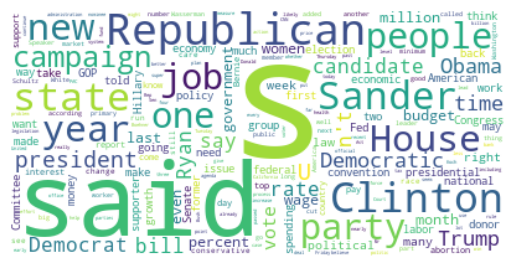

In [57]:
# Show wordclouds
plt.imshow(wc_fr, interpolation='bilinear')
plt.axis("off")
plt.show()

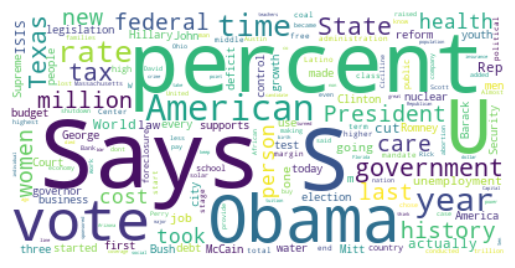

In [58]:
plt.imshow(wc_liar, interpolation='bilinear')
plt.axis("off")
plt.show()

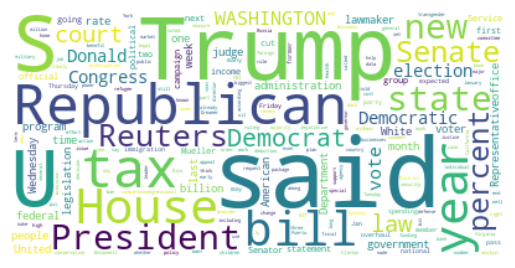

In [59]:
plt.imshow(wc_kaggle, interpolation='bilinear')
plt.axis("off")
plt.show()

The wordcloud above shows an overview of the content of the small dataset. In **Fake and Real dataset** there "S" seems to be non-contentual. The same is the case in **Liar** with the world "U". In **Kaggle** the word said and plump are the most used, which does not provide a lot of information about the content. 